### get data

In [ ]:
from google.colab import drive
import rarfile
import pandas as pd
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate, Lambda, Flatten
from tensorflow.keras.models import Model
from keras.applications import DenseNet121
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
drive.mount('/content/drive')
!pip install rarfile


rar_file_path = "/content/drive/MyDrive/approach2.rar"

destination_directory = "/content/"

with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
    rar_ref.extractall(destination_directory)

print("File extracted successfully!")


Mounted at /content/drive
File extracted successfully!


### Loading Image Data and Labels from CSV

In [2]:

labels_df = pd.read_csv("/content/image_list.csv")
data_path = "/content/aug_data_all"


def load_image_data(image_directory):
    image_data = []
    image_files = [filename for filename in os.listdir(image_directory) if filename.endswith('.jpg') or filename.endswith('.png')]
    progress_bar = tqdm(total=len(image_files), desc="Loading Images", unit="image")
    for filename in image_files:
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path)
        if image is not None:
            image_data.append(image)
        progress_bar.update(1)
    progress_bar.close()
    return image_data

image_directory = data_path
image_data = load_image_data(image_directory)
print("Number of images loaded:", len(image_data))


Loading Images: 100%|██████████| 5805/5805 [00:29<00:00, 196.27image/s]

Number of images loaded: 5805


#### Display

In [3]:
# Displaying some data of labels_df
print(labels_df.head())

# Total number of classes
total_classes = len(labels_df['diagnosis'].unique())
print("Total number of classes:", total_classes)

# Unique classes
unique_classes = labels_df['diagnosis'].unique()
print("Classes:", unique_classes)


        id_code  diagnosis
0  002c21358ce6          0
1  005b95c28852          0
2  0097f532ac9f          0
3  00cc2b75cddd          0
4  00f6c1be5a33          0
Total number of classes: 5
Classes: [0 1 2 3 4]


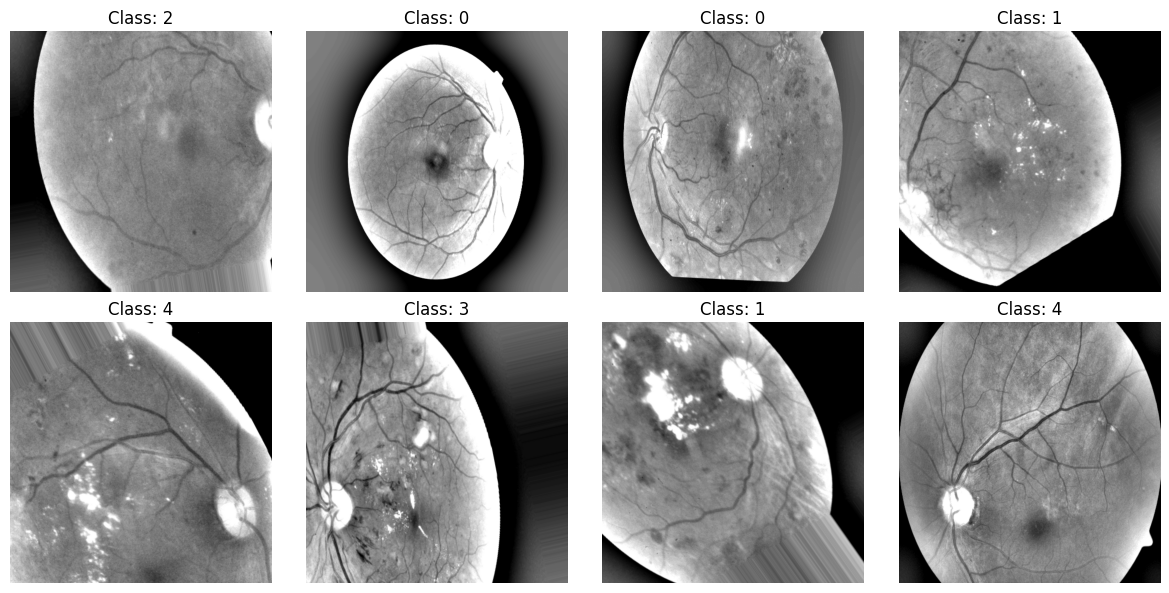

In [4]:
import random
import matplotlib.pyplot as plt

def show_random_images(image_data, labels_df, num_images_per_row=4, num_rows=2):
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(12, 6))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            idx = random.randint(0, len(image_data) - 1)
            image = image_data[idx]
            ax = axes[i, j] if num_rows > 1 else axes[j]
            ax.imshow(image)
            ax.axis('off')
            class_name = labels_df.iloc[idx]['diagnosis']
            ax.set_title(f"Class: {class_name}")

    plt.tight_layout()
    plt.show()

show_random_images(image_data, labels_df)


### Creating DataFrame and Splitting into Train, Test, and Validation Sets:


In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(labels_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)



### Setting Up Generators for Train, Test, and Validation Sets:


In [51]:
# Set up data generators
batch_size = 32
target_size = (256, 256)

# Convert the 'diagnosis' column to string type
# train_data['id_code'] = train_data['id_code'].apply(lambda x: x + ".png")
# test_data['id_code'] = test_data['id_code'].apply(lambda x: x + ".png")
# val_data['id_code'] = val_data['id_code'].apply(lambda x: x + ".png")



train_data['diagnosis'] = train_data['diagnosis'].astype(str)
test_data['diagnosis'] = test_data['diagnosis'].astype(str)
val_data['diagnosis'] = val_data['diagnosis'].astype(str)


# # Train Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=data_path,
    x_col="id_code",
    y_col="diagnosis",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Test Generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=data_path,
    x_col="id_code",
    y_col="diagnosis",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=data_path,
    x_col="id_code",
    y_col="diagnosis",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)


Found 3715 validated image filenames belonging to 5 classes.
Found 1161 validated image filenames belonging to 5 classes.
Found 743 validated image filenames belonging to 5 classes.


### The Model

In [14]:

def build_model(input_shape):
    model = Sequential()
    model.add(base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy', 'mse', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='auc') ]
    )

    return model

base = applications.DenseNet121(
    weights = 'imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
model1 = build_model((256, 256, 3))

base = applications.InceptionV3(
    weights= 'imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
model2 = build_model((256, 256, 3))

base = applications.ResNet50(
    weights= 'imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
model3 = build_model((256, 256, 3))


def build_ensemble_model(input_shape, n_out, weights=None):
    input_tensor = Input(shape=input_shape)

    base_model1 = model1
    base_model2 = model2
    base_model3 = model3

    output1 = base_model1(input_tensor)
    output2 = base_model2(input_tensor)
    output3 = base_model3(input_tensor)

    if weights is not None:
        output1 = Lambda(lambda x: x * weights[0])(output1)
        output2 = Lambda(lambda x: x * weights[1])(output2)
        output3 = Lambda(lambda x: x * weights[2])(output3)

    output1 = Flatten()(output1)
    output2 = Flatten()(output2)
    output3 = Flatten()(output3)

    merged_output = concatenate([output1, output2, output3])

    ensemble_output = Dense(n_out, activation='softmax', name='ensemble_output')(merged_output)

    model = Model(input_tensor, ensemble_output)
    return model

input_shape = (256, 256, 3)
n_out = 5
weights = [0.5, 0.3, 0.2]  #  weights for the models
model = build_ensemble_model(input_shape, n_out, weights)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 5)                    7042629   ['input_8[0][0]']             
                                                                                                  
 sequential_4 (Sequential)   (None, 5)                    2181302   ['input_8[0][0]']             
                                                          9                                       
                                                                                                  
 sequential_5 (Sequential)   (None, 5)                    2359795   ['input_8[0][0]']       

In [15]:
from tensorflow.keras import optimizers

WARMUP_LEARNING_RATE = 1e-3

for layer in model.layers:
    layer.trainable = False

for i in range(-11, 0):
    model.layers[i].trainable = True

metric_list = ['accuracy', 'mse', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='auc') ]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)


Warm up

In [16]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

WARMUP_EPOCHS = 2

session = tf.compat.v1.Session(config=config)

history_warmup = model.fit(train_generator,
                              steps_per_epoch=len(train_data) // 32,
                              validation_data=val_generator,
                              validation_steps=138,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history

Epoch 1/2
116/116 [==============================] - ETA: 0s - loss: 1.3185 - accuracy: 0.5908 - mse: 0.1328 - recall: 0.0000e+00 - auc: 0.8530

116/116 [==============================] - 342s 1s/step - loss: 1.3185 - accuracy: 0.5908 - mse: 0.1328 - recall: 0.0000e+00 - auc: 0.8530 - val_loss: 1.5111 - val_accuracy: 0.3111 - val_mse: 0.1514 - val_recall: 0.0000e+00 - val_auc: 0.6907
Epoch 2/2
116/116 [==============================] - 130s 1s/step - loss: 1.1837 - accuracy: 0.6614 - mse: 0.1189 - recall: 0.1295 - auc: 0.9088


training

In [17]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

In [18]:

# Create a TensorFlow session config
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# Create a TensorFlow session with the specified config
session = tf.compat.v1.Session(config=config)

In [19]:

# BATCH_SIZE = 8


class CustomReduceLROnPlateau(Callback):
    def __init__(self, monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0):
        super(CustomReduceLROnPlateau, self).__init__()

        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.cooldown = cooldown
        self.cooldown_counter = 0
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self.min_lr = min_lr

        if mode not in ['auto', 'min', 'max']:
            print('Mode must be one of "auto", "min", or "max".')
            self.mode = 'auto'

        if mode == 'min':
            self.monitor_op = lambda a, b: a < b - min_delta
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = lambda a, b: a > b + min_delta
            self.best = -float('inf')
        else:
            if 'acc' in self.monitor:
                self.monitor_op = lambda a, b: a > b + min_delta
                self.best = -float('inf')
            else:
                self.monitor_op = lambda a, b: a < b - min_delta
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            print(f'ReduceLROnPlateau conditioned on metric {self.monitor} which is not available. Available metrics are: {",".join(list(logs.keys()))}')

        if self.in_cooldown():
            self.cooldown_counter -= 1
            self.wait = 0

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        elif not self.in_cooldown():
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                if old_lr > self.min_lr:
                    new_lr = old_lr * self.factor
                    new_lr = max(new_lr, self.min_lr)
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: Reducing learning rate to {new_lr}')
                    self.cooldown_counter = self.cooldown
                    self.wait = 0


    def in_cooldown(self):
        return self.cooldown_counter > 0

reduce_lr_callback = CustomReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,
    patience=5,
    min_lr=0.0001
)


In [20]:

history = model.fit(train_generator,
                              steps_per_epoch=len(train_data) // 32,
                              validation_data=val_generator,
                              # validation_steps=138,
                              epochs=60,
                              callbacks=[reduce_lr_callback],
                              verbose=1)



Epoch 1/60
116/116 [==============================] - 151s 1s/step - loss: 1.0854 - accuracy: 0.6821 - mse: 0.1085 - recall: 0.2870 - auc: 0.9247 - val_loss: 1.3594 - val_accuracy: 0.5343 - val_mse: 0.1349 - val_recall: 0.0471 - val_auc: 0.7437
Epoch 2/60
116/116 [==============================] - 138s 1s/step - loss: 1.0169 - accuracy: 0.6861 - mse: 0.1015 - recall: 0.2908 - auc: 0.9307 - val_loss: 1.3122 - val_accuracy: 0.4603 - val_mse: 0.1311 - val_recall: 0.2315 - val_auc: 0.7825
Epoch 3/60
116/116 [==============================] - 137s 1s/step - loss: 0.9499 - accuracy: 0.7035 - mse: 0.0949 - recall: 0.2935 - auc: 0.9372 - val_loss: 1.1067 - val_accuracy: 0.5357 - val_mse: 0.1087 - val_recall: 0.3055 - val_auc: 0.8629
Epoch 4/60
116/116 [==============================] - 138s 1s/step - loss: 0.9055 - accuracy: 0.7106 - mse: 0.0909 - recall: 0.2960 - auc: 0.9397 - val_loss: 1.1649 - val_accuracy: 0.5518 - val_mse: 0.1167 - val_recall: 0.2261 - val_auc: 0.8397
Epoch 5/60
116/116 [

In [24]:

file_path = '/content/drive/MyDrive/outputs/training_history.json'

if os.path.exists(file_path):
    os.remove(file_path)

with open(file_path, 'w') as json_file:
    json.dump(history.history, json_file)


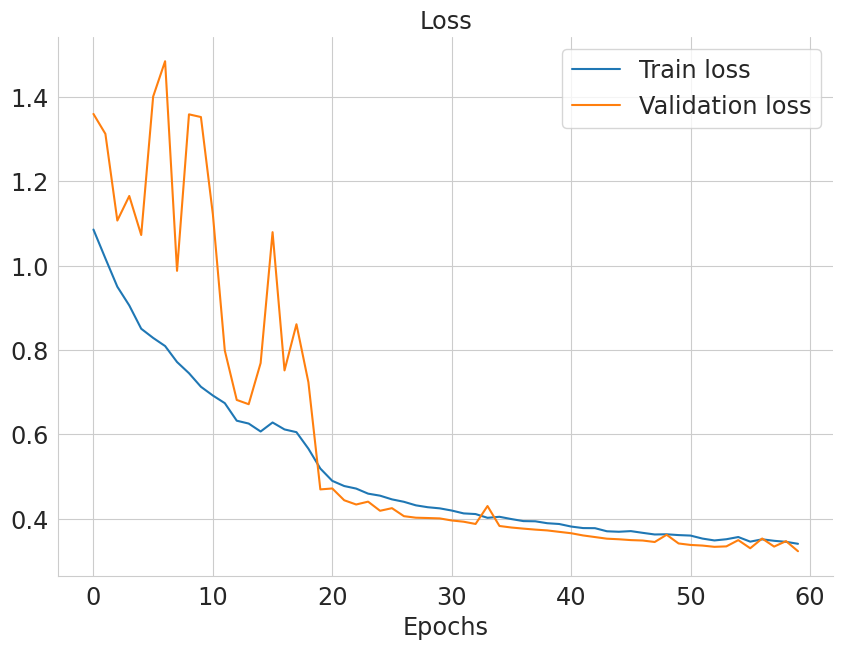

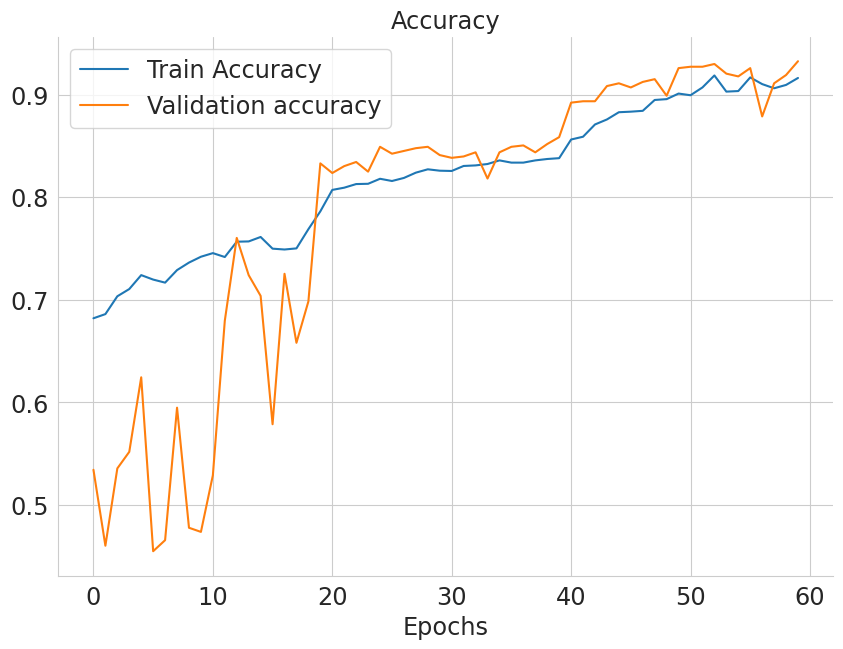

In [50]:

sns.set_style("whitegrid")

# Plot for loss
fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best', fontsize='xx-large')
ax1.set_title('Loss', fontsize='xx-large')
ax1.set_xlabel('Epochs', fontsize='xx-large')
ax1.tick_params(axis='both', which='major', labelsize='xx-large')
sns.despine()
fig1.savefig('loss.jpg')

# Plot for accuracy
fig2, ax2 = plt.subplots(figsize=(10, 7))
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best', fontsize='xx-large')
ax2.set_title('Accuracy', fontsize='xx-large')
ax2.set_xlabel('Epochs', fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize='xx-large')
sns.despine()
fig2.savefig('accuracy.jpg')


In [27]:
import os

file_path = "/content/drive/MyDrive/outputs/model_1.h5"

if os.path.exists(file_path):
    try:
        os.remove(file_path)
        print("Existing file deleted.")
    except Exception as e:
        print("Error deleting existing file:", e)

try:
    model.save(file_path)
    print("Model saved successfully.")
except Exception as e:
    print("Error saving the model:", e)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Error saving the model: Unable to create dataset (name already exists)


### Evaluating the Model

In [39]:
import numpy as np
from sklearn.metrics import classification_report

def true_and_pred_data(generator, model):
    y_true = []
    y_pred = []
    steps_per_epoch = len(generator)
    for i in range(steps_per_epoch):
        batch = generator[i]
        images = batch[0]
        labels = batch[1]
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(pred_labels)
    return y_true, y_pred

y_true, y_pred = true_and_pred_data(test_generator, model)


1/1 [==============================] - 0s 59ms/step


In [ ]:
print(len(y_true))
print(len(y_pred))


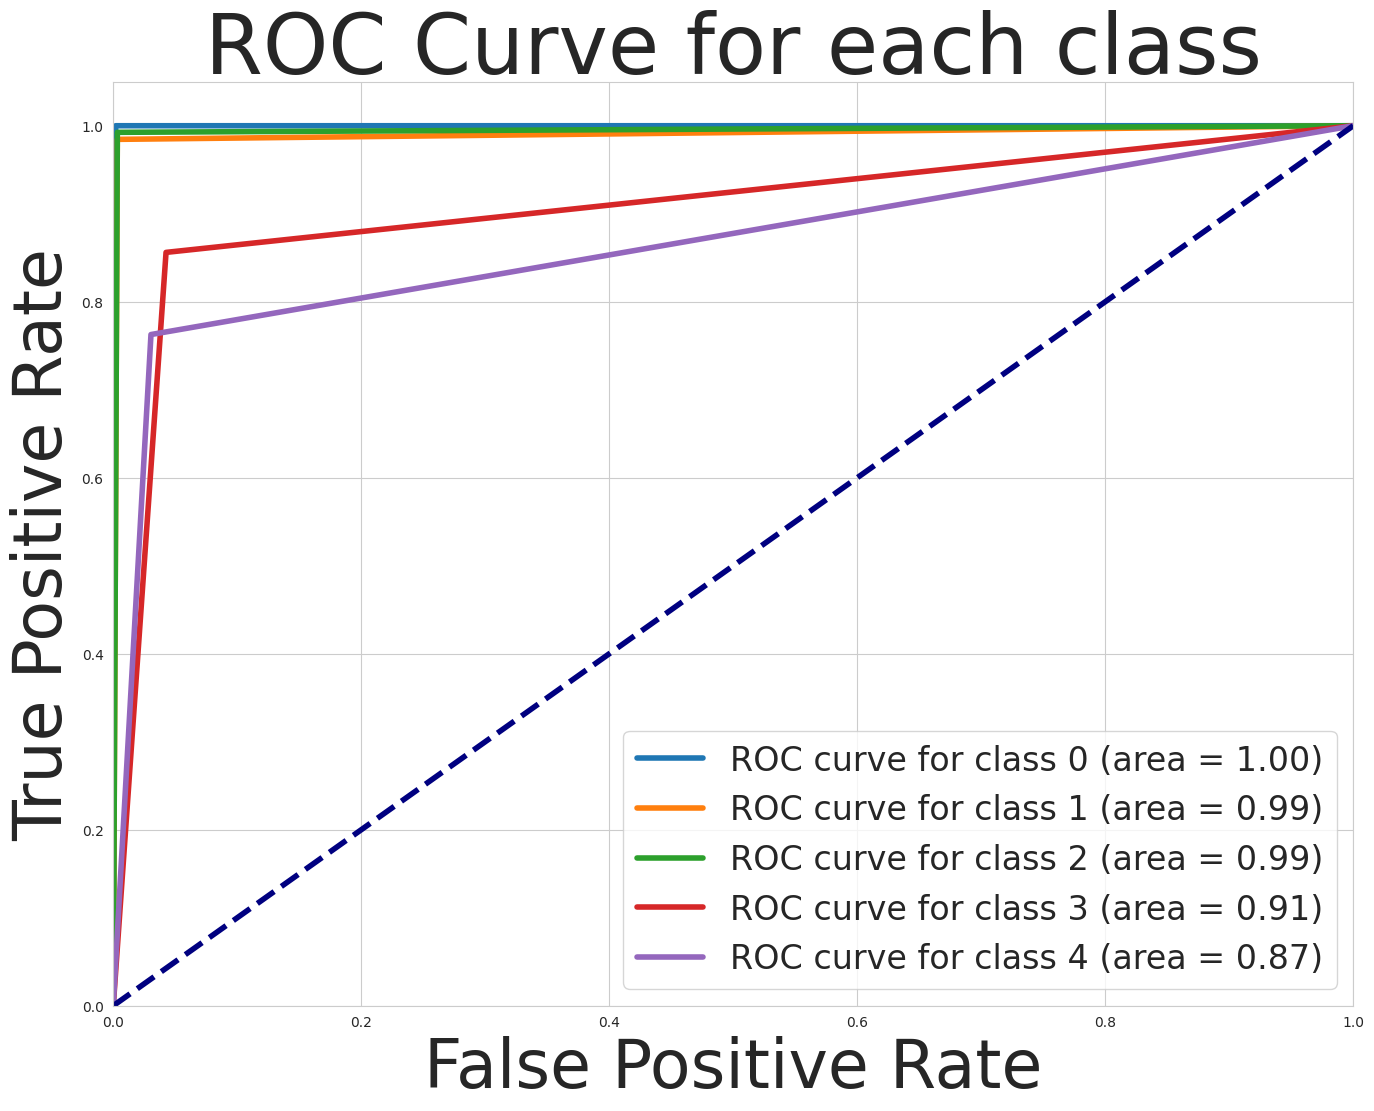

In [47]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# # Define the function to calculate the true and predicted data
# def true_and_pred_data(generator, model):
#     y_true = []
#     y_pred = []
#     steps_per_epoch = len(generator)
#     for i in range(steps_per_epoch):
#         batch = generator[i]
#         images = batch[0]
#         labels = batch[1]
#         preds = model.predict(images)
#         pred_labels = np.argmax(preds, axis=1)
#         y_true.extend(labels.argmax(axis=1))  # Extracting true labels from one-hot encoding
#         y_pred.extend(pred_labels)
#     return y_true, y_pred

# # Calculate true and predicted data
# y_true, y_pred = true_and_pred_data(test_generator, model)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(16, 12))
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=4, label='ROC curve for class %d (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=48)
plt.ylabel('True Positive Rate', fontsize=48)
plt.title('ROC Curve for each class', fontsize=60)
plt.legend(loc="lower right", prop={'size': 24})
plt.show()


In [ ]:
print(len(y_true))
print(len(y_pred))

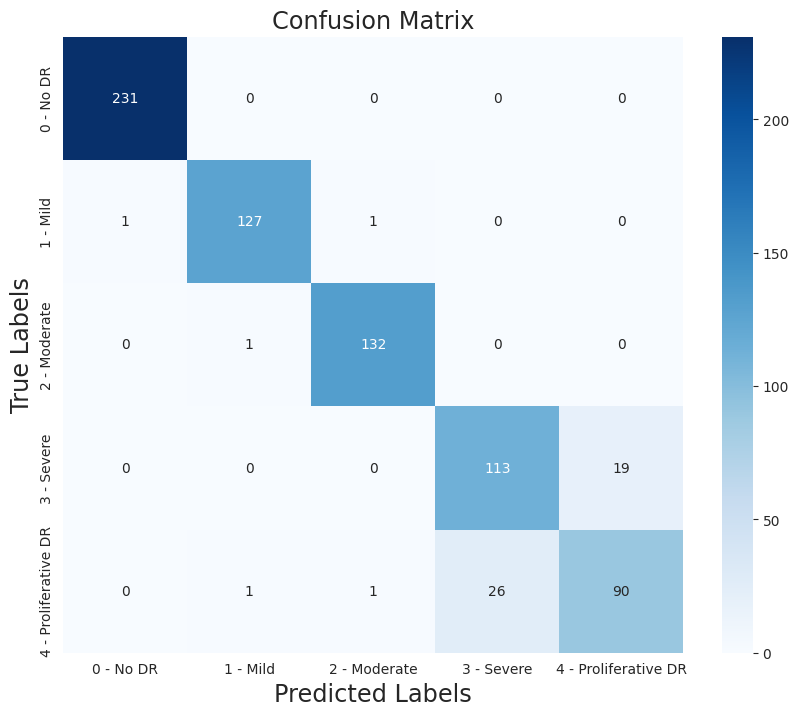

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.98      0.98      0.98       129
           2       0.99      0.99      0.99       133
           3       0.81      0.86      0.83       132
           4       0.83      0.76      0.79       118

    accuracy                           0.93       743
   macro avg       0.92      0.92      0.92       743
weighted avg       0.93      0.93      0.93       743



In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)

class_labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize='xx-large')
plt.ylabel('True Labels', fontsize='xx-large')
plt.title('Confusion Matrix', fontsize='xx-large')
plt.show()

print(classification_report(y_true, y_pred))


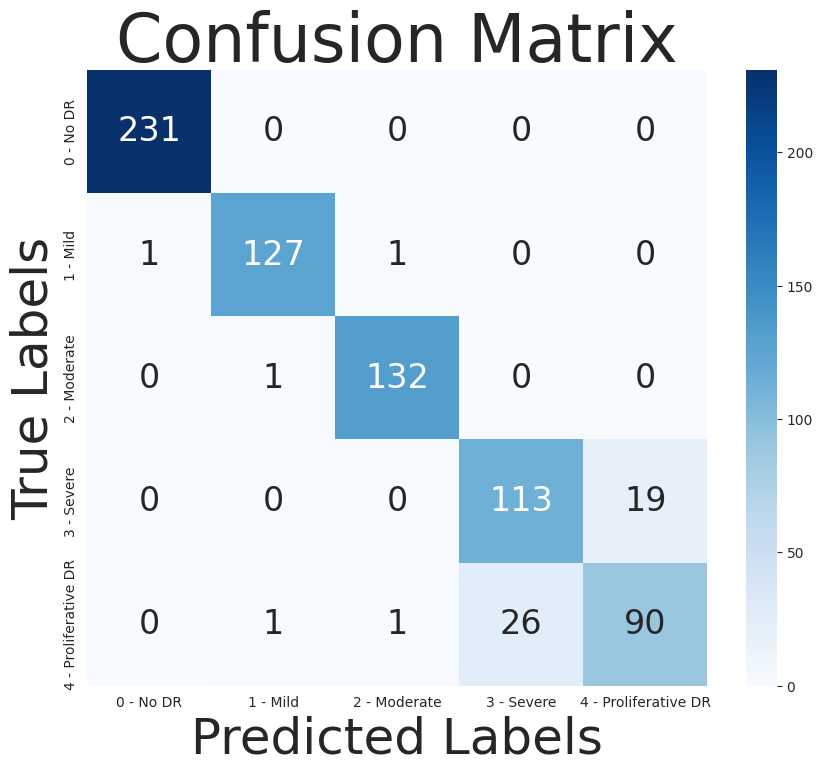

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.98      0.98      0.98       129
           2       0.99      0.99      0.99       133
           3       0.81      0.86      0.83       132
           4       0.83      0.76      0.79       118

    accuracy                           0.93       743
   macro avg       0.92      0.92      0.92       743
weighted avg       0.93      0.93      0.93       743



In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_true, y_pred)

class_labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 24})
plt.xlabel('Predicted Labels', fontsize=36)
plt.ylabel('True Labels', fontsize=36)
plt.title('Confusion Matrix', fontsize=48)
plt.show()

print(classification_report(y_true, y_pred))


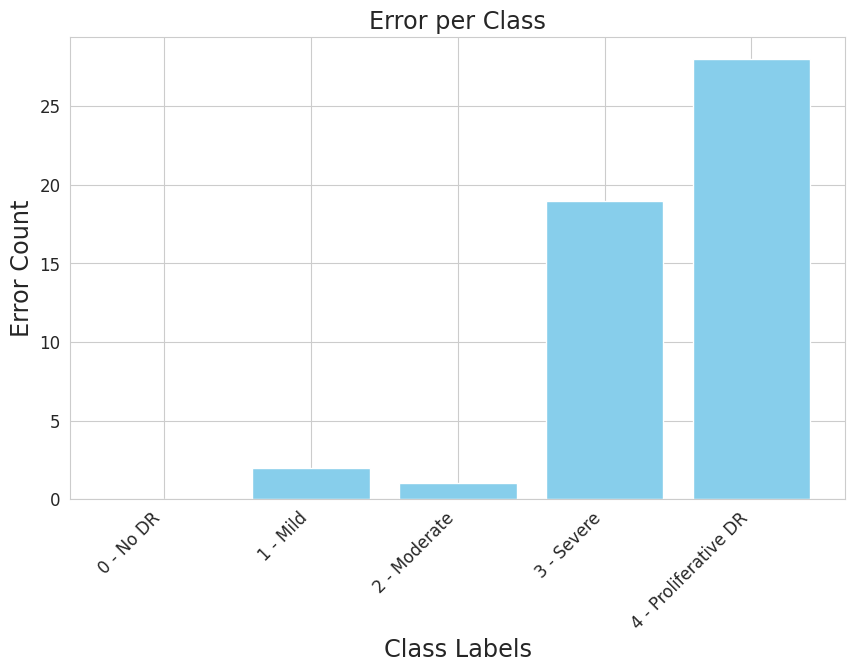

In [33]:
error_per_class = np.sum(conf_matrix - np.eye(len(class_labels)) * conf_matrix, axis=1)

# Plot error per class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, error_per_class, color='skyblue')
plt.xlabel('Class Labels', fontsize='xx-large')
plt.ylabel('Error Count', fontsize='xx-large')
plt.title('Error per Class', fontsize='xx-large')
plt.xticks(rotation=45, ha='right', fontsize='large')
plt.yticks(fontsize='large')
plt.show()


save and load

In [34]:
import os

# Specify the file path
file_path = "/content/drive/MyDrive/outputs/model_1.h5"

# Check if the file exists
if os.path.exists(file_path):
    try:
        os.remove(file_path)
        print("Existing file deleted.")
    except Exception as e:
        print("Error deleting existing file:", e)

# Save the model
try:
    model.save(file_path)
    print("Model saved successfully.")
except Exception as e:
    print("Error saving the model:", e)


Existing file deleted.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Error saving the model: Unable to create dataset (name already exists)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

STEP_SIZE_VALID = 154
num_classes = 5

eval_loss, eval_accuracy, eval_mse, eval_recall, eval_auc, eval_precision = 0, 0, 0, 0, 0, 0
y_true = []
y_pred = []

total_batches = STEP_SIZE_VALID

# Initialize progress bar
progress_bar = tqdm(total=total_batches)

for _ in range(total_batches):
    metrics = model.evaluate_generator(generator=test_generator, steps=1)

    eval_loss += metrics[0]
    eval_accuracy += metrics[1]
    eval_mse += metrics[2]
    eval_recall += metrics[3]
    eval_auc += metrics[4]

    precision = metrics[1] / (metrics[1] + metrics[3])  # True Positives / (True Positives + False Positives)
    eval_precision += precision

    progress_bar.update(1)
    progress_bar.set_description("Loss: {:.4f}, Accuracy: {:.2f}%, MSE: {:.4f}, Recall: {:.4f}, AUC: {:.4f}, Precision: {:.4f}".format(
        eval_loss / (progress_bar.n or 1),
        eval_accuracy * 100 / (progress_bar.n or 1),
        eval_mse / (progress_bar.n or 1),
        eval_recall / (progress_bar.n or 1),
        eval_auc / (progress_bar.n or 1),
        eval_precision / (progress_bar.n or 1)
    ))

    y_true.extend(test_generator.labels)
    y_pred.extend(model.predict_generator(generator=test_generator, steps=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

eval_loss /= total_batches
eval_accuracy /= total_batches
eval_mse /= total_batches
eval_recall /= total_batches
eval_auc /= total_batches
eval_precision /= total_batches

f1_score = 2 * (eval_precision * eval_recall) / (eval_precision + eval_recall)

# Print the evaluation results
print("[INFO]  Loss: {:.4f}".format(eval_loss))
print("[INFO]  Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO]  MSE: {:.4f}".format(eval_mse))
print("[INFO]  Recall: {:.4f}".format(eval_recall))
print("[INFO]  AUC: {:.4f}".format(eval_auc))
print("[INFO]  Precision: {:.4f}".format(eval_precision))
print("[INFO]  F1 Score: {:.4f}".format(f1_score))



  0%|          | 0/154 [00:00<?, ?it/s]<ipython-input-35-0584f7cb36ef>:24: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  metrics = model.evaluate_generator(generator=sec_generator, steps=1)
Loss: 0.4110, Accuracy: 84.38%, MSE: 0.0448, Recall: 0.6250, AUC: 0.9846, Precision: 0.5745:   1%|          | 1/154 [00:01<02:33,  1.00s/it]<ipython-input-35-0584f7cb36ef>:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred.extend(model.predict_generator(generator=sec_generator, steps=1))
Loss: 0.3254, Accuracy: 93.10%, MSE: 0.0346, Recall: 0.6867, AUC: 0.9945, Precision: 0.5768: 100%|██████████| 154/154 [04:49<00:00,  1.76s/it]

[INFO]  Loss: 0.3254
[INFO]  Accuracy: 93.10%
[INFO]  MSE: 0.0346
[INFO]  Recall: 0.6867
[INFO]  AUC: 0.9945
[INFO]  Precision: 0.5768
[INFO]  F1 Score: 0.6269


In [36]:
import os
from google.colab import drive
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

history_file_path = '/content/drive/MyDrive/outputs/training_history.json'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
